In [2]:
import torch
import sys

In [3]:
if 'google.colab' in str(get_ipython()):
    # Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append('gdrive/MyDrive/mldd')

    #Project dir
    project_dir = 'gdrive/MyDrive/mldd'

    # RDKit
    sys.path.append('/usr/local/lib/python3.7/site-packages/')
    try:
        from rdkit import Chem
        from rdkit.Chem.Draw import IPythonConsole
    except ImportError:
        !add-apt-repository ppa:ubuntu-toolchain-r/test
        !apt-get update --fix-missing
        !apt-get dist-upgrade
        !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
        !chmod +x Miniconda3-latest-Linux-x86_64.sh
        !./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
        !conda config --set always_yes yes --set changeps1 no
        !conda install -q -y -c conda-forge python=3.7 rdkit
        
        print('Stopping RUNTIME. Colaboratory will restart automatically. Please run cell again.')
        exit()

    #Torch Geometric
    try:
        import torch_geometric
    except ImportError:
        # Add this in a Google Colab cell to install the correct version of Pytorch Geometric.

        def format_pytorch_version(version):
            return version.split('+')[0]

        TORCH_version = torch.__version__
        TORCH = format_pytorch_version(TORCH_version)

        def format_cuda_version(version):
            return 'cu' + version.replace('.', '')

        CUDA_version = torch.version.cuda
        CUDA = format_cuda_version(CUDA_version)

        !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-geometric 

else:
    from rdkit import Chem
    from rdkit.Chem.Draw import IPythonConsole
    sys.path.append('.')
    project_dir = '.'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from mldd.data import Featurizer
import numpy as np

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)
            graph = self.process_mol(mol)
            graphs.append(graph)
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

    def process_mol(self, mol):
        edges = []
        for bond in mol.GetBonds():
            edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
            edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
        edges = np.array(edges)
            
        nodes = []
        for atom in mol.GetAtoms():
            results = one_of_k_encoding_unk(
                atom.GetSymbol(),
                [
                    'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                ]
            ) + one_of_k_encoding(
                atom.GetDegree(),
                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
            ) + one_of_k_encoding_unk(
                atom.GetImplicitValence(),
                [0, 1, 2, 3, 4, 5, 6]
            ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                atom.GetHybridization(),
                [
                    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                    Chem.rdchem.HybridizationType.SP3D2
                ]
            ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                atom.GetTotalNumHs(),
                [0, 1, 2, 3, 4]
            )
            nodes.append(results)
        nodes = np.array(nodes)

        return (nodes, edges.T)

In [6]:
from torch_geometric.data import InMemoryDataset, Data  # TODO

class GraphDataset(InMemoryDataset):  # TODO
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        
        self.download()
        self.process()

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        data = []
        # TODO (data should be a list of graphs)

        for (nodes, edges), target in zip(*self.dataset):
            nodes = torch.tensor(nodes, dtype=torch.float)
            edges = torch.tensor(edges, dtype=torch.long)
            target = torch.tensor(target, dtype=torch.float)
            
            graph = Data(x=nodes, edge_index=edges, y=target)
            graph.num_nodes = nodes.shape[0]
            data.append(graph)

        torch.save(data, self.raw_paths[0])
        

    def process(self):
        # Read data into huge `Data` list.
        data_list = torch.load(self.raw_paths[0])
        
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [7]:
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, Sequential as GraphSequential

from torch.nn import ReLU
from torch_geometric.nn import GCNConv, Linear, global_mean_pool

class GCNRegressor(torch.nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()

        self.input = None
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(input, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, hidden)
        self.conv4 = GCNConv(hidden, output)
        self.linear = Linear(output, 1)
        self.relu = ReLU(inplace=True)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch):
        x.requires_grad = True
        self.input = x

        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.conv3(x, edge_index)
        x = self.relu(x)
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(x, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)

        x = global_mean_pool(self.final_conv_acts, batch=batch)
        x = self.linear(x)

        return x

In [8]:
from mldd.data import load_esol

def train(X_train, y_train, X_valid, y_valid):
    # hyperparameters definition
    hidden_size = 512
    epochs = 50
    batch_size = 64
    learning_rate = 0.0001
    
    # model preparation
    model = GCNRegressor(input=len(X_train[0][0][0]), hidden=hidden_size, output=64)  # TODO
    model.train()
    
    # data preparation
    dataset = GraphDataset(X_train, y_train.reshape(-1, 1), root='esol-train')
    loader = GraphDataLoader(dataset, batch_size=batch_size, shuffle=True, )
    
    # training loop
    optimizer = torch.optim.Adam(params=model.parameters())  # TODO
    loss_fn = torch.nn.MSELoss()  # TODO
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            
            model.zero_grad()
            preds = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()
    return model


def predict(model, X_test, y_test):
    # hyperparameters definition
    # (but this doesn't change the training results, it's only to optimize the eval speed)
    batch_size = 64

    # data preparation
    dataset = GraphDataset(X_test, y_test.reshape(-1, 1), root='esol-test')
    loader = GraphDataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(loader):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            preds = model(x, edge_index, batch)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds

In [9]:
df, fold_indices = load_esol(split_path= project_dir + '/data/esol/split.npz')
featurizer = GraphFeaturizer(y_column='measured log solubility in mols per litre')
scores = []

In [10]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader

from typing import List, Tuple

from mldd.metrics import mae, rmse, rocauc, r_squared
from mldd.data import *

# for train_data, valid_data, test_data in cross_validate(df, fold_indices, preprocessing_fn=featurizer):
#     X_train, y_train = train_data
#     X_valid, y_valid = valid_data
#     X_test, y_test = test_data
            
#     # training
#     modelG = train(X_train, y_train, X_valid, y_valid)
    
#     # # evaluation
#     predictions = predict(modelG, X_test, y_test)
    
#     rmse_score = rmse(y_test, predictions.flatten())
#     mae_score = mae(y_test, predictions.flatten())
#     r2_score = r_squared(y_test, predictions.flatten())
#     scores.append([rmse_score, mae_score, r2_score])
    
#     break  # can be removed to get results on all folds
# scores = np.array(scores)
# print('RMSE, MAE, R2 = ' + \
#       ', '.join(f'{mean:.2f}±{std:.3f}' for mean, std in zip(scores.mean(axis=0), scores.std(axis=0))))

In [11]:
# torch.save(modelG, project_dir + '/GCNRegressor.pth')

In [12]:
modelG = torch.load(project_dir + '/GCNRegressor.pth')

# Bonus: Interpretowalność - Grad-CAM dla grafów

$$
\alpha_k^{l,c}=\frac{1}{N}\sum_{n=1}^N \frac{\partial y^c}{\partial F_{k,n}^l},\\
L^c(l,n) = ReLU\left(\sum_k \alpha_k^{l,c} F_{k,n}^l (X, A)\right)
$$

In [13]:
import torch.nn.functional as F

def grad_cam(final_conv_acts, final_conv_grads):
    node_heat_map = []
    alphas = torch.mean(final_conv_grads, axis=0)  # TODO (formula 1)
    for n in range(final_conv_acts.shape[0]): # nth node
        node_heat = F.relu(alphas @ final_conv_acts[n]).item()  # TODO (formula 2)
        node_heat_map.append(node_heat)
    return node_heat_map

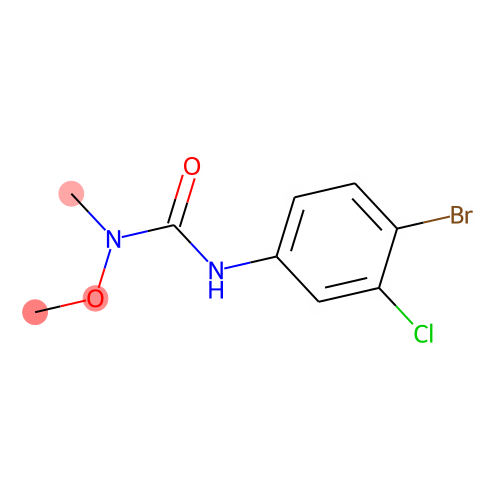

In [14]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

import matplotlib
import matplotlib.cm as cm

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

compound_idx = 60
mol = Chem.MolFromSmiles(df.iloc[fold_indices[0][compound_idx]].smiles)

graphs, labels = featurizer(df.iloc[fold_indices[0][compound_idx]].to_frame().transpose())
X = graphs[0][0]
E = graphs[0][1]
y = labels[0]
data = Data(
    x=torch.FloatTensor(X),
    edge_index=torch.LongTensor(E),
    y=torch.tensor(y)
)

x, edge_index, batch = data.x, data.edge_index, data.batch

modelG(x, edge_index, torch.zeros(x.shape[0], dtype=torch.int64))
atom_weights = grad_cam(modelG.final_conv_acts, modelG.final_conv_grads)
atom_weights = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(atom_weights).reshape(-1, 1)).reshape(-1, )

atom_weights = np.array(atom_weights)
if (atom_weights > 0.).any():
    atom_weights = atom_weights / atom_weights.max() / 2

if len(atom_weights) > 0:
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {
        i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))
    }
    highlight_kwargs = {
        'highlightAtoms': list(range(len(atom_weights))),
        'highlightBonds': [],
        'highlightAtomColors': atom_colors
    }

d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, **highlight_kwargs)
d.FinishDrawing()
svg = d.GetDrawingText()
svg = svg.replace('svg:', '')
SVG(svg)

In [15]:
def saliency_map(input_grads):
    # print('saliency_map')
    node_saliency_map = []
    for n in range(input_grads.shape[0]): # nth node
        node_grads = input_grads[n,:]
        node_saliency = torch.norm(F.relu(node_grads)).item()
        node_saliency_map.append(node_saliency)
    return node_saliency_map

In [16]:
out = modelG(x, edge_index, torch.zeros(x.shape[0], dtype=torch.int64))
loss =  torch.nn.MSELoss()(out, torch.tensor(labels.reshape(-1, 1), dtype=torch.float32))
loss.backward()

In [17]:
saliency_atom_weights = saliency_map(modelG.input.grad)

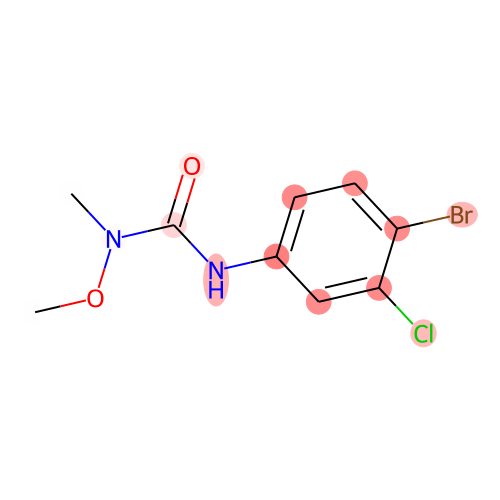

In [18]:
saliency_atom_weights = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(saliency_atom_weights).reshape(-1, 1)).reshape(-1, )
if (saliency_atom_weights > 0.).any():
    saliency_atom_weights = saliency_atom_weights / saliency_atom_weights.max() / 2

if len(saliency_atom_weights) > 0:
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {
        i: plt_colors.to_rgba(saliency_atom_weights[i]) for i in range(len(saliency_atom_weights))
    }
    highlight_kwargs = {
        'highlightAtoms': list(range(len(saliency_atom_weights))),
        'highlightBonds': [],
        'highlightAtomColors': atom_colors
    }

d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, **highlight_kwargs)
d.FinishDrawing()
svg = d.GetDrawingText()
svg = svg.replace('svg:', '')
SVG(svg)

# My Interpretability Method

-3.606299638748169 / -3.924


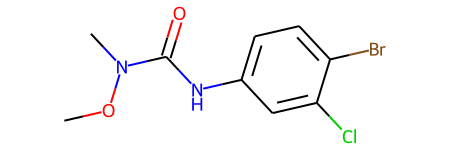

In [19]:
from rdkit.Chem.rdchem import RWMol

batch = torch.zeros(x.shape[0], dtype=torch.int64)
original = modelG(data.x, data.edge_index, batch).item()

print(original, '/', labels[0])
mol

In [20]:
def replace_atom(mol, target, destination):
    molRW = RWMol(mol)
    molRW.ReplaceAtom(target.GetIdx(), destination, preserveProps=True)
    molRW.UpdatePropertyCache()

    return molRW

def replace_atom_num(mol, target, destination):
    molRW = RWMol(mol)
    molRW.GetAtoms()[target.GetIdx()].SetAtomicNum(destination.GetAtomicNum())
    molRW.UpdatePropertyCache()

    return molRW

In [21]:
%%capture
from rdkit.Chem import Atom, AtomValenceException

def calc_absolute(preds):
    preds = np.array(preds)
    absolute = np.abs(original - preds)
    not_nans = absolute[~np.isnan(absolute)]
    atom_weight = not_nans.mean() if len(not_nans) != 0 else np.nan
    
    return atom_weight


def calc_signed(preds):
    preds = np.array(preds)
    diff = preds - original
    not_nans = diff[~np.isnan(diff)]
    atom_weight = not_nans.mean() if len(not_nans) != 0 else np.nan

    return atom_weight

def calc_atom_weights(mol, replace_with, replace_func, log, calc_weight_fuc):
    atom_weights = []

    for atom in mol.GetAtoms():
        preds = []

        if replace_with == 'all':
            organic_atoms = [Atom(symbol) for symbol in  ['Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S']]
            for organic_atom in organic_atoms:
                preds.append(output_replaced(mol, atom, organic_atom, replace_func, log))
        elif replace_with == 'zero':
            preds.append(output_replaced(mol, atom, None, replace_func, log))
        else:
            organic_atom = Atom(replace_with)
            preds.append(output_replaced(mol, atom, organic_atom, replace_func, log))

        atom_weights.append(calc_weight_fuc(preds))

    return atom_weights

def output_replaced(mol, atom, organic_atom, replace_func, log):
    try:
        # if atom.GetAtomicNum() == organic_atom.GetAtomicNum():
            # return 0

        if organic_atom:
            molRW = replace_func(mol, atom, organic_atom)
            if log:
                print(f'before replacement {atom.GetSymbol()} at {atom.GetIdx()}:', Chem.MolToSmiles(mol))
                print(f'after  replacement {atom.GetSymbol()} at {atom.GetIdx()}:', Chem.MolToSmiles(molRW))
            nodes, edges = featurizer.process_mol(molRW)
        else:
            nodes, edges = featurizer.process_mol(mol)
            nodes[atom.GetIdx()][:11] = torch.zeros((11,))
            

        data_replaced = Data(
            x=torch.FloatTensor(nodes),
            edge_index=torch.LongTensor(edges)
        )

        output_replaced = modelG(data_replaced.x, data_replaced.edge_index, batch).item()

        if log:
            if organic_atom:
                print(f'Replacing {atom.GetSymbol()} with {organic_atom.GetSymbol()} resulted in {output_replaced}')
            
        return output_replaced
    except AtomValenceException:
        if log:
            if organic_atom:
                print(f"Replacing {atom.GetSymbol()} with {organic_atom.GetSymbol()} failed.")
        return np.nan

In [22]:
def get_atom_colors(atom_weights):
    atom_weights = np.array(atom_weights, dtype=np.float)
    positive_idx = atom_weights > 0
    
    if positive_idx.any():
        atom_weights[positive_idx] = MinMaxScaler(feature_range=(0,1)).fit_transform(atom_weights[positive_idx].reshape(-1, 1)).reshape(-1, )
    if ~positive_idx.any():
        atom_weights[~positive_idx] = MinMaxScaler(feature_range=(-1,0)).fit_transform(atom_weights[~positive_idx].reshape(-1, 1)).reshape(-1, )

    atom_weights /= 2.0

    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap= cm.get_cmap('RdYlGn')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)

    atom_colors = {
        i: plt_colors.to_rgba(atom_weights[i]) if ~np.isnan(atom_weights[i]) else (0.701, 0.631, 0.988) for i in range(len(atom_weights))
    }

    return atom_colors


In [25]:
%%capture --no-display --no-stdout
from ipywidgets import interact
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

@interact(replace_with=['all', 'zero', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S'], replace_func=[replace_atom_num, replace_atom], calc_weight_func=[calc_signed, calc_absolute], log=False)
def draw_importance(replace_with='all', replace_func=replace_atom_num, calc_weight_func=calc_signed, log=False):
    if log:
        print(f'original {original}')

    atom_weights = calc_atom_weights(mol, replace_with, replace_func, log, calc_weight_func)

    if len(atom_weights) > 0:
        atom_colors = get_atom_colors(atom_weights)
        highlight_kwargs = {
            'highlightAtoms': list(range(len(atom_weights))),
            'highlightBonds': [],
            'highlightAtomColors': atom_colors
        }

    for idx, atom in enumerate(mol.GetAtoms()):
        if ~np.isnan(atom_weights[idx]):
            atom.SetProp('atomNote', f'{atom.GetIdx()} : {atom_weights[idx]:2.3}')
        else:
            atom.SetProp('atomNote', f'{atom.GetIdx()} : Not replaceable')

    d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, **highlight_kwargs)
    d.FinishDrawing()
    svg = d.GetDrawingText()
    svg = svg.replace('svg:', '')
    return SVG(svg)

interactive(children=(Dropdown(description='replace_with', options=('all', 'zero', 'Br', 'C', 'Cl', 'F', 'H', …

In [24]:
gradient = np.linspace(0, 1, 256).reshape((1, 256))

figure = plt.figure(figsize=(4, 2), dpi=80)

plt.imshow(gradient, aspect=10, cmap='RdYlGn', vmin=0.0, vmax=1.0)
plt.xticks([0, 255], ['negative', 'positive'])
plt.yticks([])
plt.close()

NameError: name 'plt' is not defined

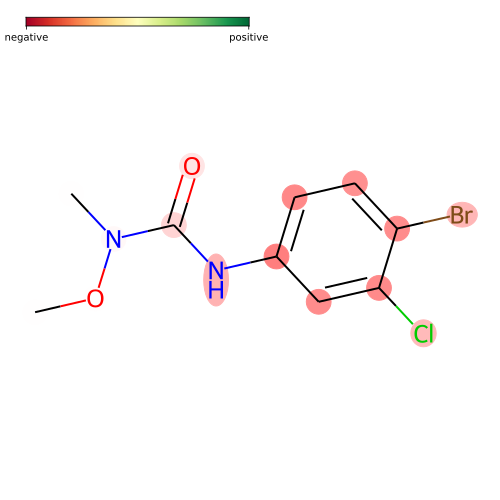

In [ ]:
import svgutils.transform as sg

fig = sg.fromstring(svg)
im2 = sg.from_mpl(figure).getroot()
im2.moveto(-10, -50)

fig.append(im2)

SVG(fig.to_str())


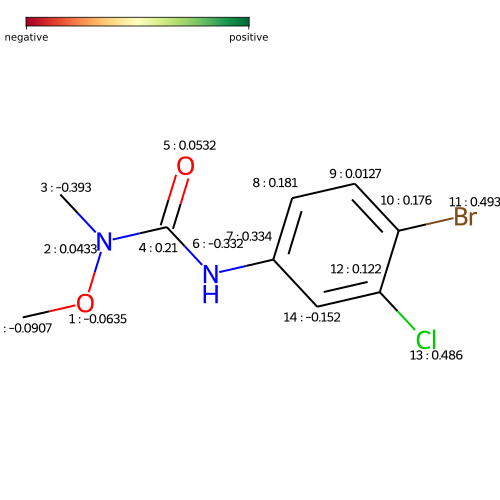

In [ ]:
SVG(fig.to_str())